In [43]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import cvxpy  as cp
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
assets = ['SPY', 'EFA', 'EEM', 'PSP', 'QAI', 'HYG', 'DBC', 'IYR', 'IEF', 'BWX', 'TIP', 'SHV']

start = "2010-01-01"
end = "2022-12-31"

In [50]:
df = yf.download(assets, start, end)['Adj Close']
df.head()

[*********************100%%**********************]  12 of 12 completed


,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SHV,SPY,TIP
Date,,,,,,,,,,,,
2010-01-04,23.982328,23.234581,32.429028,37.994476,39.688232,67.079704,28.448311,38.011726,23.598112,97.784058,87.129944,73.683777
2010-01-05,24.095951,23.262199,32.664413,38.027966,39.876514,67.374298,28.516607,38.419125,23.658333,97.748573,87.360580,73.924248
2010-01-06,24.053873,23.676441,32.732735,38.188709,39.979603,67.102432,28.504200,38.622841,23.701344,97.757446,87.422073,73.733284
2010-01-07,23.915001,23.381868,32.542915,38.041363,40.141003,67.102432,28.758823,38.826534,23.641123,97.757446,87.791122,73.846413
2010-01-08,24.053873,23.363457,32.801071,38.342751,40.203777,67.185493,28.566301,38.948765,23.701344,97.792961,88.083282,74.002075


In [51]:
price = df.resample('M').last()
price = price.subtract(ret['SHV'], axis=0)

In [54]:
ret = price.pct_change().dropna()
ret = ret.drop(columns = ['SHV'])
ret.head()

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2010-04-30,-0.014475,0.039116,-0.001662,-0.028046,0.019245,0.016527,0.063881,0.018182,-0.001838,0.015470,0.025151
2010-05-31,-0.036446,-0.101473,-0.093936,-0.111928,-0.046755,0.029332,-0.056836,-0.128969,-0.041621,-0.079455,0.001917
2010-06-30,0.011479,-0.017759,-0.013986,-0.020620,0.011112,0.030483,-0.046701,-0.059091,0.014989,-0.051741,0.012799
2010-07-31,0.061023,0.061196,0.109325,0.116105,0.051532,0.009096,0.094049,0.111650,0.026127,0.068301,-0.002429
2010-08-31,0.017184,-0.030144,-0.032367,-0.037950,-0.009896,0.033560,-0.012972,-0.052401,0.001845,-0.044980,0.019420


In [55]:
ex_ret = ret.subtract(ret['SHV'], axis=0)
#ex_ret = ex_ret.drop(columns = ['SHV'])
ex_ret

KeyError: 'SHV'

### 1)

In [40]:
def performance_summary(retsx):
    summary = retsx.mean().to_frame('Annualized Return') * 12
    summary['Annualized volatility'] = retsx.std()*np.sqrt(12)
    summary['Annualized Sharpe Ratio'] = summary['Annualized Return']/ summary['Annualized volatility']
    return summary

In [41]:
performance_summary(ret)

,Annualized Return,Annualized volatility,Annualized Sharpe Ratio
BWX,-0.007462,0.080966,-0.092161
DBC,0.016427,0.177323,0.092640
EEM,0.030709,0.187093,0.164139
EFA,0.054791,0.162059,0.338090
HYG,0.042017,0.080654,0.520950
IEF,0.020040,0.060694,0.330186
IYR,0.091672,0.166712,0.549883
PSP,0.034650,0.221748,0.156260
QAI,0.012592,0.050760,0.248067
SHV,0.000000,0.000000,NaN


### 2)

In [42]:
best_sharp = performance_summary(ex_ret)['Annualized Sharpe Ratio'].idxmax()
worst_sharp = performance_summary(ex_ret)['Annualized Sharpe Ratio'].idxmin()

print(f"Найкращий: {best_sharp}")
print(f"Найгірший: {worst_sharp}")

Найкращий: SPY
Найгірший: BWX


### 3)

In [44]:
asset_corr = ret.corr()
asset_corr

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SHV,SPY,TIP
BWX,1.000000,0.316244,0.637959,0.604906,0.609413,0.410249,0.495075,0.544440,0.661190,NaN,0.443850,0.596871
DBC,0.316244,1.000000,0.561381,0.588162,0.539048,-0.357194,0.369323,0.549112,0.538109,NaN,0.520350,0.117154
EEM,0.637959,0.561381,1.000000,0.837749,0.706435,-0.117328,0.591988,0.771669,0.792120,NaN,0.714546,0.315336
EFA,0.604906,0.588162,0.837749,1.000000,0.794709,-0.158739,0.693590,0.908965,0.853229,NaN,0.869232,0.292971
HYG,0.609413,0.539048,0.706435,0.794709,1.000000,0.038198,0.735285,0.827446,0.810082,NaN,0.795914,0.476025
IEF,0.410249,-0.357194,-0.117328,-0.158739,0.038198,1.000000,0.128283,-0.125931,0.053714,NaN,-0.179086,0.699738
IYR,0.495075,0.369323,0.591988,0.693590,0.735285,0.128283,1.000000,0.749450,0.684940,NaN,0.764924,0.528893
PSP,0.544440,0.549112,0.771669,0.908965,0.827446,-0.125931,0.749450,1.000000,0.855385,NaN,0.911559,0.377903
QAI,0.661190,0.538109,0.792120,0.853229,0.810082,0.053714,0.684940,0.855385,1.000000,NaN,0.839589,0.475627
SHV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


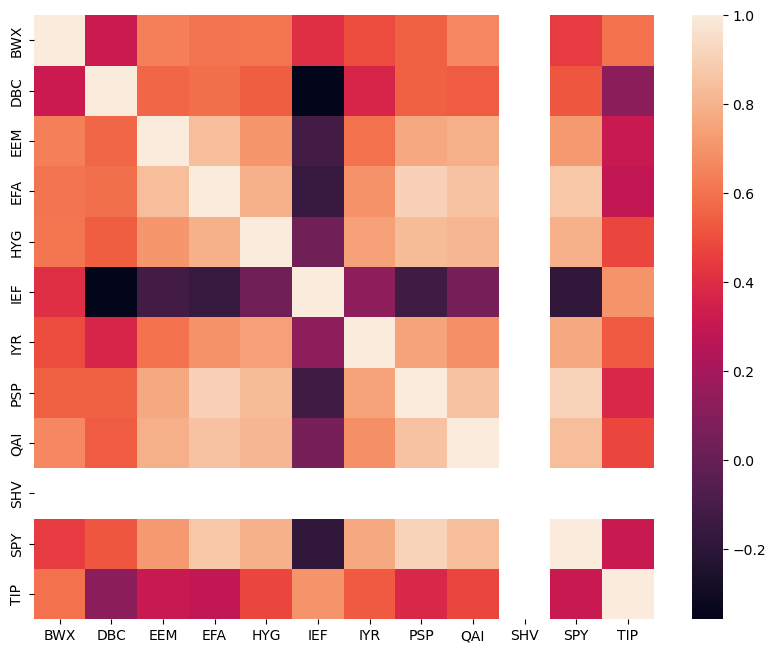

In [48]:
plt.figure(figsize=(10, 8), dpi=100)
heatmap = sns.heatmap(asset_corr)